### Function to return some characteristics of the dataset 

In [114]:
# Define a function to return some characteristics of the dataset  
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = cv2.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

### Function to return HOG features and visualization

In [115]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

### Function to compute binned color features

In [116]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

### Function to compute color histogram features 

In [117]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Function to extract features from a list of images, this function call bin_spatial() and color_hist()

In [118]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
   
    # Define HOG parameters
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features


### Function to train the SVC model with "non-vehicle" and "vehicle" dataset and the save the trained model to the disk

In [119]:
#Function to train the SVC model
def train_model():
    cars = []
    notcars = []
    
    # Define HOG parameters
    color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    hist_range = (0, 256)
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off

    images = glob.glob('./non-vehicles/non-vehicles/*/*.png')
    for image in images:
        notcars.append(image)
    images = glob.glob('./vehicles/vehicles/*/*.png')
    for image in images:
        cars.append(image)

    data_info = data_look(cars, notcars)

    print('Your function returned a count of', 
          data_info["n_cars"], ' cars and', 
          data_info["n_notcars"], ' non-cars')
    print('of size: ',data_info["image_shape"], ' and data type:', 
          data_info["data_type"])

    # Just for fun choose random car / not-car indices and plot example images   
    car_ind = np.random.randint(0, len(cars))
    notcar_ind = np.random.randint(0, len(notcars))

    # Read in car / not-car images
    car_image = cv2.imread(cars[car_ind])
    notcar_image = cv2.imread(notcars[notcar_ind])

    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(convertForDisaply(car_image))
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(convertForDisaply(notcar_image))
    plt.title('Example Not Car Image')
    ofname = "./output_images/" + "car_notcar_example.png"
    plt.savefig(ofname)

    # Convert to Gray image
    gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)

    # Call our function with vis=True to see an image output
    features, hog_image = get_hog_features(gray, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)

    # Plot the hog examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(convertForDisaply(car_image))
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Visualization')
    ofname = "./output_images/" + "hog_example.png"
    plt.savefig(ofname)

    #Combine and Normalize Features
    car_features = extract_features(cars, cspace='RGB', spatial_size = spatial_size,
                                    hist_bins = hist_bins , hist_range = hist_range)
    notcar_features = extract_features(notcars, cspace='RGB', spatial_size = spatial_size,
                                    hist_bins = hist_bins , hist_range =hist_range)

    if len(car_features) > 0:
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)
        # Plot an example of raw and scaled features
        fig = plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.imshow(convertForDisaply(cv2.imread(cars[car_ind])))
        plt.title('Original Image')
        plt.subplot(132)
        plt.plot(X[car_ind])
        plt.title('Raw Features')
        plt.subplot(133)
        plt.plot(scaled_X[car_ind])
        plt.title('Normalized Features')
        fig.tight_layout()
        ofname = "./output_images/" + "raw_normalized_features_example.png"
        plt.savefig(ofname)
    else: 
        print('Your function only returns empty feature vectors...')

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts    : ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    
    #Save the model
    joblib.dump(svc, fileName) 
    joblib.dump(X_scaler, scalerFileName) 

### Image draw_boxes function 

In [120]:
# Here is your draw_boxes function 
def draw_boxes(img, bboxes, color, thick):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Sliding Window function that takes an image, start and stop positions in both x and y, window size (x and y dimensions), and overlap fraction (for both x and y)

In [121]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop, y_start_stop, xy_window, xy_overlap):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [122]:
# Multiple size windows

def slide_window_multiple(img):
    #windows_small = slide_window(img, x_start_stop=[None, None], y_start_stop=[400, 496],xy_window=(32, 32), xy_overlap=(0.5, 0.5))
    windows_small = slide_window(img, x_start_stop=[None, None], y_start_stop=[400, 528], xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    windows_medium = slide_window(img, x_start_stop=[None, None], y_start_stop=[400, 592], xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    windows_large = slide_window(img, x_start_stop=[None, None], y_start_stop=[336, 720], xy_window=(128, 128), xy_overlap=(0.5, 0.5)) 
    
    return windows_small + windows_medium + windows_large

### For imgae display converting back to RGB

In [123]:
def convertForDisaply(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

### Define a function to extract features from a single image window
### This function is very similar to extract_features() just for a single image rather than list of images

In [124]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

### Function you will pass an image and the list of windows to be searched (output of slide_windows())

In [125]:
# Define a function you will pass an image and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

### Adding heatmap

In [126]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    heatmap[heatmap != 0] -= 1
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

### Applying hetmap threshold

In [127]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

### To draw boxes on each predicted car

In [128]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img

### Function to process each test images/frames

In [129]:
def process_image(image):
    global heat
    global video_processing
    
    # Define HOG parameters
    color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    hist_range = (0, 256)
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [None, None] # Min and max in y to search in slide_window()
    if(video_processing):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        windows = slide_window_multiple(image)
    else:
        windows = slide_window_multiple(image)
        window_img = draw_boxes(image, windows, color=(255, 0, 0), thick=6) 
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(convertForDisaply(image))
        plt.title('Test Car Image')
        plt.subplot(122)
        plt.imshow(convertForDisaply(window_img))
        plt.title('Mulitple Sliding Window')
        ofname = "./output_images/" + "test6_sliding_window.png"
        plt.savefig(ofname)
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    window_img = draw_boxes(image, hot_windows, color=(255, 0, 0), thick=6)  
    
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    if(video_processing):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        result = draw_labeled_bboxes(np.copy(image), labels)
    else:
        result = draw_labeled_bboxes(np.copy(image), labels)
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(convertForDisaply(result))
        plt.title('Car Positions')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
        ofname = "./output_images/" + "test6_heatmap.png"
        plt.savefig(ofname)

    return result

In [130]:
# Heatmap filtering
def captureFrames():
    vidcap = cv2.VideoCapture('test_video.mp4')
    success,image = vidcap.read()
    count = 0
    success = True
    while success:
      success,image = vidcap.read()
      cv2.imwrite("./output_images/heatmap_frames/frame%d.jpg" % count, image)     # save frame as JPEG file
      count += 1

In [131]:
# Heatmap filtering
def testOnFrames(frames):
    for frame in frames:
        img = cv2.imread(frame)
        result = process_image(img)
        outputfile = frame
        cv2.imwrite(outputfile, result)
    print("Succesfully processed frame images")

### Main to train the model, process test images and project video

Model is already trained! Reloading the trained model....
Completed the processing of test imgaes successfully!!!
(720, 1280)
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [40:13<00:01,  1.83s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Completed the video processing successfully!!!


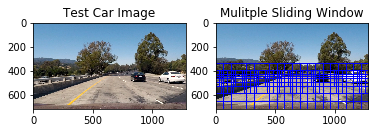

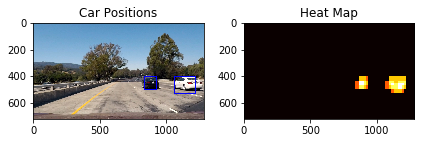

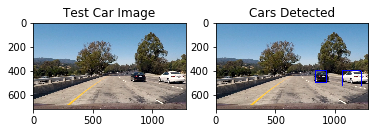

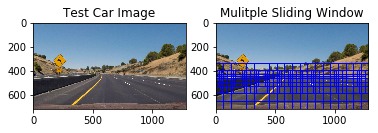

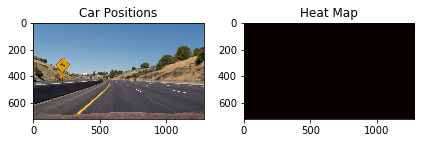

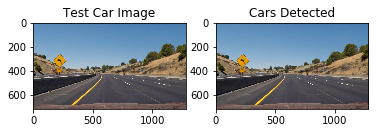

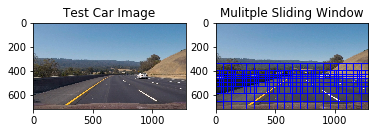

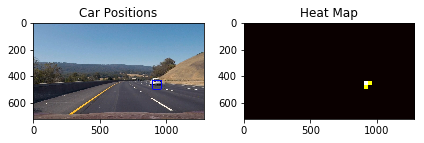

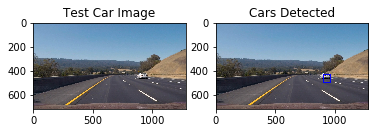

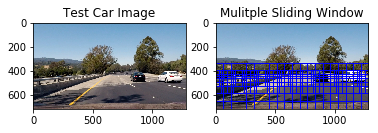

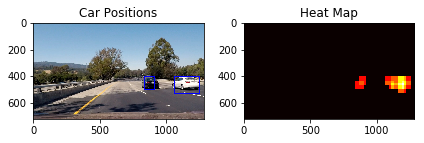

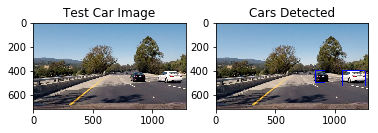

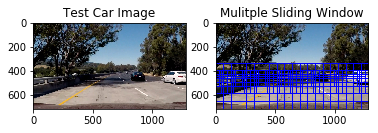

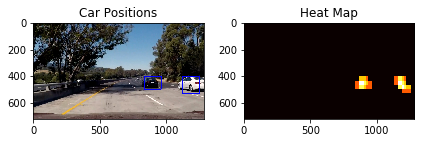

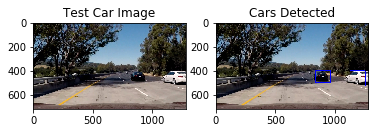

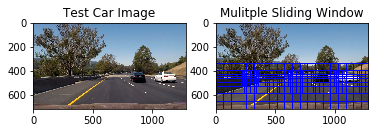

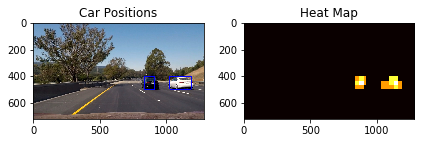

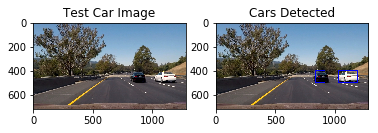

In [132]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
import os
from skimage.feature import hog
from skimage import color, exposure
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from sklearn.externals import joblib
from moviepy.editor import VideoFileClip
%matplotlib inline

#To load/train the model
fileName = "svcmodel.pkl"
scalerFileName="xscalermodel.pkl"
if os.path.isfile(fileName):
    print("Model is already trained! Reloading the trained model....")
    svc = joblib.load(fileName)
    X_scaler = joblib.load(scalerFileName)
else:
    train_model()

# Heatmap filtering
'''
captureFrames()
frames = glob.glob('./output_images/heatmap_frames/*.jpg')
video_processing = False
firstFrame = cv2.imread(frames[0])
heat = np.zeros_like(firstFrame[:,:,0]).astype(np.float)   
testOnFrames(frames)
'''
#To process test images
video_processing = False
testimages = glob.glob('./test_images/*.jpg')
for testimage in testimages:
    image = cv2.imread(testimage)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    timage= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    out_image = process_image(image)
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(timage)
    plt.title('Test Car Image')
    plt.subplot(122)
    plt.imshow(convertForDisaply(out_image))
    plt.title('Cars Detected')
    ofname = "./output_images/" + "test6_final_output.png"
    plt.savefig(ofname)
    #plt.show()
print("Completed the processing of test imgaes successfully!!!")
    
#Reset heat for video processing
heat = np.zeros_like(image[:,:,0]).astype(np.float) 
print(heat.shape)
project_output = 'project_video_output.mp4'
video_processing = True
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(process_image)
out_clip.write_videofile(project_output, audio=False)
print("Completed the video processing successfully!!!")

In [133]:
from IPython.display import HTML

HTML("""
<video width="1280" height="720" controls>
  <source src="project_video_output.mp4" type="video/mp4">
</video>
""")